# Model

## Kevin Shain

### 04/10/2016

In [3]:
%matplotlib inline 

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numpy.random import random as rng
import pandas as pd
import seaborn as sns
import emcee
import math
from numpy import pi
from qubitparameterestimation import myio
from qubitparameterestimation import model

# Table of Contents
* [Generative Models](#Generative-Models)
    * [Long time-scale errors](#Long-time-scale-errors)
	* [Model without drift or diffusion](#Model-without-drift-or-diffusion)
	* [Model with drift](#Model-with-drift)
	* [Model with drift and diffusion](#Model-with-drift-and-diffusion)
* [Likelihood function](#Likelihood-function)
* [Further ideas](#Further-ideas)

# Generative Models

Because each measurement of a qubit probabilistically projects the a superposition state that exists somewhere on the qubit's Bloch sphere onto either the singlet or triplet state that is read out, my model is inherently probabilistic. Therefore, beyond adding random noise to the model, my model will generate probabilities of each measurement outcome and then randomly generate singlet(+1) or triplet(-1) for the measurement outcome.

Another important aspect to these models is that there are different timescales for different effects. Some parameters, like measurement error, state preparation error, and non-orthogonal axis of rotation, are consistent throughout the lifetime of the qubit. This means that we can accurately measure values for those error parameters over thousands or millions of measurements. This means that for real-time or limited measurement purposes, we can focus on the parameters that vary over a shorter time scale, like $\Delta B_z$ and its drift and diffusion. This tends to vary significantly on a time scale of a millisecond compared to measurements that take ~4 microseconds.

## Long time-scale errors

In general, we can say that the state of our qubit without noise is,

$$\left|\psi(t)\right>=\cos(\pi\Delta B_z t)\left|+\right>-i\sin(\pi\Delta B_z t)\left|-\right>$$

The probabilities for a given outcome as it depends on $\Delta B_z$ is therefore,

$$P(+|\Delta B_z)=\cos^2(\pi\Delta B_z t)$$
$$P(-|\Delta B_z)=\sin^2(\pi\Delta B_z t)$$

This simple model of the probabilities doesn't consider any errors, but it is important to note that it will still generate a random measurement outcome with defined proabilities so we will not be able to fit data from this model exactly even if we know $\Delta B_z$. The first source of error that I'll consider is measurement error. Essentially, the readout of the qubit is done by measuring voltage across another quantum dot. This gives well differentiated Gaussian peaks of voltage depending on the qubit state. These peaks are then thresholded so that the singlet(triplet) peak is marked +(-). This thresholding process is imperfect as there is some small chance that a tail from the singlet Gaussian will leak into the triplet Gaussian or vice versa. Ideally, I would not do the thresholding as that is an extra step of data processing. It is unclear whether the added complexity of using raw voltage measurements is worth the computational cost, but I'll make a model that generates voltage measurements later so that comparisons can be made. For now, I'll simply work with $\pm$ but include a measurement error term.

With measurement error, the probability of measuring a + is essentially the probability of measuring + correctly plus the probability of measuring - incorrectly. If we say that the probability of incorrectly measuring +(-) is $\eta_+(\eta_-)$, this gives us,

$$P(+|\Delta B_z)=(1-\eta_+)\cos^2(\pi\Delta B_z t)+\eta_-\sin^2(\pi\Delta B_z t)$$
$$P(-|\Delta B_z)=\eta_+\cos^2(\pi\Delta B_z t)+(1-\eta_-)\sin^2(\pi\Delta B_z t)$$

We can account for state preparation error in a similar way. The initial state would ideally be purely singlet every time, but it actually is prepared in the triplet state some small percentage of the time. This means that the initial density matrix is,

$$\begin{pmatrix}
 1-\epsilon & 0 \\ 
 0 & \epsilon
 \end{pmatrix}$$
 
Accounting for just state preparation error, we would have,

$$P(+|\Delta B_z)=(1-\epsilon)\cos^2(\pi\Delta B_z t)+\epsilon\sin^2(\pi\Delta B_z t)$$
$$P(-|\Delta B_z)=\epsilon\cos^2(\pi\Delta B_z t)+(1-\epsilon)\sin^2(\pi\Delta B_z t)$$

Finally, we have axis of rotation error. This accounts for small differences in the electric potential between the two quantum dots that make up the qubit. This shifts the axis of rotation on the Bloch sphere about which the state vector rotates. This error alone leads to,

$$P(+|\Delta B_z)=\cos^2(\pi\Delta B_z t)+\delta\sin^2(\pi\Delta B_z t)$$
$$P(-|\Delta B_z)=(1-\delta)\sin^2(\pi\Delta B_z t)$$

Putting the all of the errors together and using $\cos^2(x)-\sin^2(x)=\cos(2x)$, we get,

$$P(+|\Delta B_z)=\eta_-+\frac{1}{2}(1-\eta_+-\eta_-)[1+(1-2\epsilon)(\delta+(1-\delta)\cos(2\pi\Delta B_zt))]$$ 
$$P(-|\Delta B_z)=\eta_++\frac{1}{2}(1-\eta_+-\eta_-)[1-(1-2\epsilon)(\delta+(1-\delta)\cos(2\pi\Delta B_zt))]$$ 


We can combine these probabilities into one if we say the result of any measurement is $m_k=\pm 1$ so,

$$P(m_k|\Delta B_z)=\eta_-+\frac{1}{2}(1-\eta_+-\eta_-)[1+m_k(1-\epsilon)(\delta+(1-\delta)\cos(2\pi\Delta B_zt))]$$

We can reparameterize our long time-scale errors using

$$\alpha=\eta_--\eta_++(1-\eta_--\eta_+)(\delta-2\epsilon\delta)$$
$$\beta=(1-\eta_--\eta_+)(1-\delta)(1-2\epsilon)$$

to get,

$$P(m_k|\Delta B_z)=\frac{1}{2}[1+m_k(\alpha+\beta\cos(2\pi\Delta B_zt))]$$


Though it seems that reparameterizing our errors sacrifices clarity, it turns out that $\alpha$ and $\beta$ are more easily extracted since repeatedly measuring immediately after preparation yields $p(+)=\frac{1}{2}[1+\alpha+\beta]$ and simply making lots of measurements at random times and averaging gives $p(+)=\frac{1}{2}[1+\alpha]$

## Model without drift or diffusion

This analysis lets us come to the simplest generative model which accounts for long time-scale errors, but doesn't account for drift and diffusion in $\Delta B_z$. That will come later.

In [4]:
def measurement(Bz,t):
    """
    returns either +1 or -1 with probability determined by the model for qubit evolution
    and projective measurement
    
    Parameters:
        Bz: Initial value of DeltaBz in the model (in MHz)
        t: evolution time between state preparation and measurement (in nanoseconds)
    """
    alpha=0.25
    beta=0.67
    BzHertz = Bz*10**6
    tseconds = t*10**(-9)
    pPlus = 1/2*(1+(alpha+beta*np.cos(2*pi*BzHertz*tseconds)))
    x = np.random.rand(1)[0]
    if (pPlus > x):
        x = 1
    else:
        x = -1
    return x

As mentioned before, if we wanted to generate the voltage measurement, we could draw the voltage value from a Gaussian peaked at voltage corresponding to the singlet or triplet state. The mean and variance of these Gaussian peaks also have long time scales so we can specify them based on many previous measurements.

In [5]:
def measurementVoltage(Bz,t):
    """
    returns a voltage value from a Gaussian peak based on the qubit state measurement.
    The qubit state measurement is determined by the model for qubit evolution
    and projective measurement.
    
    Parameters:
        Bz: Initial value of DeltaBz in the model (in MHz)
        t: evolution time between state preparation and measurement (in nanoseconds)
    """
    alpha=0.25
    beta=0.67
    Smean = 4.5
    Sstd = 0.3
    Tmean = 5.5
    Tstd = 0.3
    
    BzHertz = Bz*10**6
    tseconds = t*10**(-9)
    pPlus = 1/2*(1+(alpha+beta*np.cos(2*pi*BzHertz*tseconds)))
    x = np.random.rand(1)[0]
    if (pPlus > x):
        voltage = np.random.norm(Smean,Sstd)
    else:
        voltage = np.random.norm(Tmean,Tstd)
    return voltage

## Model with drift

To address drift in $\Delta B_z$, we can use the approximation that $\Delta B_z$ is constant within the measurement evolution time of a single measurement. A reasonable estimate of the drift is $25kHz/\mu s$. The evolution times of a single measurement are 10-100 ns which justifies this approximation. However, each measurement in total takes $~4\mu s$ so we have to take into account the drift between measurements.

In [6]:
def measurementDrift(Bz,t,drift,k):
    """
    returns either +1 or -1 with probability determined by the model for qubit evolution
    and projective measurement
    
    Parameters:
        Bz: Initial value of DeltaBz in the model (in MHz)
        t: evolution time between state preparation and measurement (in nanoseconds)
        drift: rate of drift of DeltaBz in kHz/us
        k: measurement index
    """
    alpha=0.25
    beta=0.67
    driftHzs = drift*10**9 #units of Hz/s
    timePerMeasurement = 4*10**(-6)
    
    BzHertz = Bz*10**6
    tseconds = t*10**(-9)
    
    BzCurrent = BzHertz - driftHzs*timePerMeasurement*(k-1)
    pPlus = 1/2*(1+(alpha+beta*np.cos(2*pi*BzCurrent*tseconds)))
    x = np.random.rand(1)[0]
    if (pPlus > x):
        x = 1
    else:
        x = -1
    return x

## Model with drift and diffusion

To address diffusion in $\Delta B_z$, we again use the approximation that $\Delta B_z$ is constant within the measurement evolution time of a single measurement. A reasonable estimate of the diffusion is $7 kHz^2/\mu s$. We want to first define a function that executes a random walk of $\Delta B_z$ that has the desired diffusion constant. This means, that we want,

$$\frac{\partial P}{\partial t}=D\frac{\partial^2 P}{\partial x^2}$$

We can solve this to say,

$$P(x,t) = \frac{1}{\sqrt{4\pi Dt}}e^{-x^2/4Dt}$$

Therefore, if we say that each step in our random walk is $1\mu s$, we can use our probability distribution to choose an updated $\Delta B_z$ such that it follows the proper rate of diffusion.

In [7]:
def randomWalk(Bz):
    """
    returns a vector with Bz values that have diffused over time. Each step is 1 microsecond
    so in practice, each consequtive measurement pulls its DeltaBz from every fourth
    value in the vector
    
    Parameters:
        Bz: Initial value of DeltaBz in the model (in MHz)
    """
    D = 7*10**(-6) # need to change from kHz^2 to MHz^2
    
    steps = 10000 # This allows for plenty of time to make ~100 measurements
    BzDiffused = np.empty(steps)
    BzDiffused[0] = Bz
    sigma = np.sqrt(2*D)
    for t in range(1,steps):
        BzDiffused[t] = np.random.normal(BzDiffused[t-1], sigma)
    return BzDiffused

In [8]:
def measurementDriftDiffusion(BzDiffused,t,drift,k):
    """
    returns either +1 or -1 with probability determined by the model for qubit evolution
    and projective measurement
    
    Parameters:
        BzDiffused: A vector of Bz values at 1 microsecond increments(in MHz)
        t: evolution time between state preparation and measurement (in nanoseconds)
        drift: rate of drift of DeltaBz in kHz/us
        k: measurement index
    """
    alpha=0.25
    beta=0.67
    driftHzs = drift*10**9 #units of Hz/s
    timePerMeasurement = 4*10**(-6)
    
    
    BzHertz = BzDiffused[4*k]*10**6 # each measurement looks at every 4th value of BzDiffused
                                    # since a measurement takes 4 microseconds
    tseconds = t*10**(-9)
    
    BzCurrent = BzHertz - driftHzs*timePerMeasurement*(k-1)
    pPlus = 1/2*(1+(alpha+beta*np.cos(2*pi*BzCurrent*tseconds)))
    x = np.random.rand(1)[0]
    if (pPlus > x):
        x = 1
    else:
        x = -1
    return x

# Likelihood function

In some sense, obtaining a likelihood function from the model is straightforward because before projecting the state to + or -, our model gives probabilities of + or -. This means that to find the likelihood of a series of measurements, we can take the product of the probability that each measurement would result in the outcome that was actually obtained. This is complicated a bit by the fact that our parameters are changing between measurements in a non-deterministic way. Specifically, the diffusion means that we have uncertainty in our parameter $\Delta B_z$ and that this uncertainty changes across the series of measurements. To account for this, I'll integrate my likelihood over the possible values of $\Delta B_z$. Our parameters are thus the initial $\Delta B_z$ and its drift, which together determine the mean value, and the diffusion constant that determines the variance of $\Delta B_z$ values that we must integrate over to get the likelihood of each measurement.

The likelihood of a single measurement given a value of $\Delta B_z$ is given by 

$$P(m_k|\Delta B_z)=\frac{1}{2}[1+m_k(\alpha+\beta\cos(2\pi\Delta B_zt))]$$

However, since we are saying that $\Delta B_z$ drifts at some rate per measurement time, $v$, we should say,

$$P(m_k|\Delta B_z)=\frac{1}{2}[1+m_k(\alpha+\beta\cos(2\pi(\Delta B_z+vk)t)]$$

Finally, the diffusion of $\Delta B_z$ with a diffusion constant per measurement time, $D$, means that we can say there is a distribution for $\Delta B_z$ at each measurement given by,

$$\Delta B_{z_k}=\frac{1}{\sqrt{4\pi Dk}}e^{-[\Delta B_{z_k}-(\Delta B_{z_0}+vk)]^2/4Dk}$$

Combining everything we have for a single measurement, we have,

$$P(m_k|\Delta B_{z_0},v,D)=\int_{-\infty}^\infty\frac{1}{\sqrt{4\pi Dk}}e^{-[\Delta B_{z_k}-(\Delta B_{z_0}+vk)]^2/4Dk}\frac{1}{2}[1+m_k(\alpha+\beta\cos(2\pi(\Delta B_z+vk)t)]d\Delta B_{z_k}$$


Finally, we can write the likelihood for a series of measurements as,

$$P(\{m\}|\Delta B_{z_0},v,D)=\prod_k\int_{-\infty}^\infty\frac{1}{\sqrt{4\pi Dk}}e^{-[\Delta B_{z_k}-(\Delta B_{z_0}+vk)]^2/4Dk}\frac{1}{2}[1+m_k(\alpha+\beta\cos(2\pi(\Delta B_z+vk)t)]d\Delta B_{z_k}$$

To actually implement this, we can evaluate the Gaussian integral for $P(m_k|\Delta B_{z_0},v,D)$. This is done by decomposing the cosine term into exponentials and then integrating the complex Gaussian analytically. If we say that the current value of $\Delta B_z$ taking into account just the initial value and drift is $\Delta B_{zc}$, then we have,

$$P(m_k|\Delta B_{zc},v,D)=\int_{-\infty}^\infty\frac{1}{\sqrt{4\pi Dk}}e^{-[\Delta B_{z_k}-\Delta B_{zc}]^2/4Dk}\frac{1}{2}[1+m_k(\alpha+\beta\cos(2\pi\Delta B_{zc}t)]d\Delta B_{z_k}$$
$$=\frac{1}{2}\sqrt{2Dk}e^{-(2\pi t)^2(2Dk)/2}\beta m_k\cos(2\pi\Delta B_{zc}t)+\frac{1}{2}\left(1+\alpha*m_k\right)$$

We can code this up by making a loop that updates the value of $\Delta B_{zc}$ and $\sqrt{2Dk}$ for each measurement and then multiplies the likelihood of that measurement to the total likelihood of the data.

In [9]:
def likelihood(MetaSeries,Bz):
    alpha = MetaSeries.alpha
    beta = MetaSeries.beta
    drift = MetaSeries.drift*10**9
    diffusion = MetaSeries.diffusion*10**(-6)
    BzHertz = Bz*10**6
    
    timePerMeasurement = 4*10**(-6)
    
    likelihood=1
    
    for i in range(len(MetaSeries)):
        k = MetaSeries[i,0]+1
        tk = MetaSeries[i,1]*10**(-9)
        mk = MetaSeries[i,2]
        
        BzCurrent = BzHertz - drift*timePerMeasurement*(k+1)
        sigma = np.sqrt(2*diffusion*4*k)
        
        likelihoodmk = 1/2*beta*mk*sigma*np.exp(-(2*pi*tk)**2*sigma**2/2)*np.cos(2*pi*BzCurrent*tk)+(1+mk*alpha)/2
        likelihood = likelihood*likelihoodmk
    return likelihood

# Sample Inference

First, I'll load a sample dataset generated with a $\Delta B_z$ of 60MHz.

In [11]:
test = myio.loadData('singleSeries.csv')

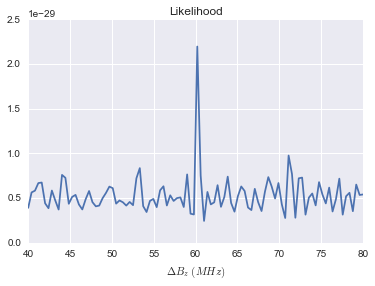

In [18]:
Bz = np.linspace(40,80,100)
plt.plot(Bz,likelihood(test,Bz))
plt.title('Likelihood')
plt.xlabel(r'$\Delta B_z\,\,(MHz)$')

# Further ideas

I believe that this likelihood is computable. I don't see a reason why it shouldn't be. However, I have a notion that I can use the fact that the likelihood of each measurement is in the form of a cosine to turn the likelihood or the posterior into a finite Fourier series. I can do this using the identity that transforms a product of cosines into a sum of cosines. My thought is that this will significantly save on computation time because certain expectation values can be calculated just from Fourier coefficients without having to evaluate the likelihood at various values of $\Delta B_z$. I've been reading a book on spectral analysis and I believe that this should be a viable technique. Furthermore, drift and diffusion can be handled very naturally in the frequency representation.